In [15]:
import sys
import os

parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)

from synth_dim_model import *

import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [16]:
def construct_new_hamiltonian(N, M, V1, mu, J, theta = 0, boundary_conditions = "OBC", chemical_potential_loc = 0, V2 = 0):
    """Placeholder definition."""        
    dim = M**N
    H = np.zeros((dim, dim), dtype=np.complex128)

    # Precompute powers of M for faster state-to-index conversion
    M_powers = np.array([M**i for i in range(N)])

    def index_to_state(index):
        return np.array([(index // M_powers[i]) % M for i in range(N-1, -1, -1)])
    
    # Helper function to convert a state representation (array of states) back to an index
    def state_to_index(state):
        return np.dot(state, M_powers[::-1])

    # Apply the chemical potential term
    for alpha in range(dim):
        state = index_to_state(alpha)
        for j in range(N):
            if state[j] == chemical_potential_loc:
                H[alpha, alpha] -= mu
                    
    # Apply the tunneling term
    for alpha in range(dim):
        state = index_to_state(alpha)
        for j in range(N):
            for n in range(M):
                if state[j] == n:
                    if n == 0:
                        if boundary_conditions == "PBC":
                            new_state = state.copy()
                            new_state[j] = M - 1
                            beta = state_to_index(new_state)
                            H[alpha, beta] -= J
                            H[beta, alpha] -= J
                        elif boundary_conditions == "OBC":
                            pass
                        
                    else:
                        new_state = state.copy()
                        new_state[j] = n - 1
                        beta = state_to_index(new_state)
                        
                        if n == 1:
                            H[alpha, beta] -= J*np.exp(1j*theta)
                            H[beta, alpha] -= J*np.exp(-1j*theta)
                            
                        else:
                            H[alpha, beta] -= J
                            H[beta, alpha] -= J 


    # Nearest-neighbor (V1) and next-nearest-neighbor (V2)
    for alpha in range(dim):
        state = index_to_state(alpha)
        
        # Nearest-neighbor (V)
        for i in range(N - 1):
            j = i + 1
            for n in range(M):
                if n == 0:
                    if boundary_conditions == "PBC":
                        if state[i] == 0 and state[j] == M - 1:
                            new_state = state.copy()
                            new_state[i], new_state[j] = M - 1, 0
                            beta = state_to_index(new_state)
                            H[alpha, beta] += V1
                            H[beta, alpha] += V1  
                else:
                    if state[i] == n and state[j] == n - 1:
                        new_state = state.copy()
                        new_state[i], new_state[j] = n - 1, n
                        beta = state_to_index(new_state)
                        H[alpha, beta] += V1
                        H[beta, alpha] += V1 

        # Next-nearest-neighbor (V2)
        for i in range(N - 2):
            j = i + 2
            for n in range(M):
                if n == 0:
                    if boundary_conditions == "PBC" and N > 2:
                        if state[i] == 0 and state[j] == M - 1:
                            new_state = state.copy()
                            new_state[i], new_state[j] = M - 1, 0
                            beta = state_to_index(new_state)
                            H[alpha, beta] += V2
                            H[beta, alpha] += V2  
                else:
                    if state[i] == n and state[j] == n - 1:
                        new_state = state.copy()
                        new_state[i], new_state[j] = n - 1, n
                        beta = state_to_index(new_state)
                        H[alpha, beta] += V2
                        H[beta, alpha] += V2  

    return H


In [17]:
N = 3
M = 2

H = construct_new_hamiltonian(N, M, V1 = 1, V2 = 0.1, mu = 0, J = 1)
print(np.real(H))

[[ 0.  -1.  -1.   0.  -1.   0.   0.   0. ]
 [-1.   0.   1.  -1.   0.1 -1.   0.   0. ]
 [-1.   1.   0.  -1.   1.   0.  -1.   0. ]
 [ 0.  -1.  -1.   0.   0.   1.   0.1 -1. ]
 [-1.   0.1  1.   0.   0.  -1.  -1.   0. ]
 [ 0.  -1.   0.   1.  -1.   0.   1.  -1. ]
 [ 0.   0.  -1.   0.1 -1.   1.   0.  -1. ]
 [ 0.   0.   0.  -1.   0.  -1.  -1.   0. ]]


In [18]:
def single_site_number_operator(N, M, site_index, synth_level, states):
    dim = M**N
    number_operator_matrix = np.zeros((dim, dim), dtype=np.complex128)
    
    for k in range(dim):
        if states[k][site_index] == synth_level:
            number_operator_matrix[k,k] = 1
             
    return number_operator_matrix

def construct_ground_state_projector(eigenvalues, eigenvectors, epsilon=1e-9):
    ground_energy = np.min(eigenvalues)
    indices = np.where(np.abs(eigenvalues - ground_energy) <= epsilon)[0]
    
    # Stack degenerate eigenvectors into a 2D array: shape (dim, num_degenerate)
    degenerate_states = [eigenvectors[i] for i in indices]
    V = np.column_stack(degenerate_states)

    # Construct the projector: P = V V†
    P = V @ V.conj().T

    return P, degenerate_states

def compute_entanglement_entropy(N, M, psi, cut_site):
    psi_tensor = psi.reshape([M] * N)
    d_left = M ** cut_site
    d_right = M ** (N - cut_site)
    psi_matrix = psi_tensor.reshape(d_left, d_right)
    s = np.linalg.svd(psi_matrix, compute_uv=False)
    s = s / np.linalg.norm(s)
    s2 = s**2
    return -np.sum(s2 * np.log(s2 + 1e-12))


In [ ]:
N = 4
M = 3
V = 1
V2 = 0.1

states, _ = enumerate_states(N, M)

Js = np.linspace(0, 2, 50)
mus = np.linspace(0, 2, 50)

entropy_grid = np.zeros((len(mus), len(Js)), dtype=np.float64)

# Loop
for i, mu in enumerate(mus):
    for j, J in enumerate(Js):
        hamiltonian = construct_new_hamiltonian(N, M, V, mu, J, V2 = V2)
        eigenvalues, eigenvectors = exact_diagonalize(hamiltonian)

        P, degenerate_states = construct_ground_state_projector(eigenvalues, eigenvectors)
        d = len(degenerate_states)

        # Entanglement entropy (bipartition in the middle)
        entropies = [compute_entanglement_entropy(N, M, psi, cut_site=N // 2) for psi in degenerate_states]
        entropy_grid[i, j] = np.mean(entropies)
        
fig, ax = plt.subplots(figsize=(7, 5))
c = ax.imshow(
    entropy_grid,
    origin='lower',
    aspect='auto',
    extent=[Js[0], Js[-1], mus[0], mus[-1]],
    cmap='plasma'
)
fig.colorbar(c, ax=ax, label=r'Entanglement entropy $S$')
ax.set_xlabel("J")
ax.set_ylabel(r"$\mu$")
ax.set_title(f"$N = {N}$, $M = {M}$, $V_1 = {V}, V_2 = {V2}$: bipartite entropy [cut @ {N//2}]")
plt.tight_layout()
plt.show()


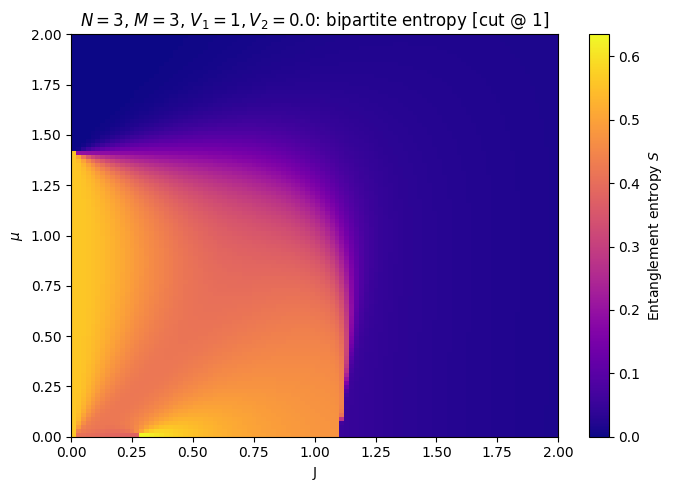

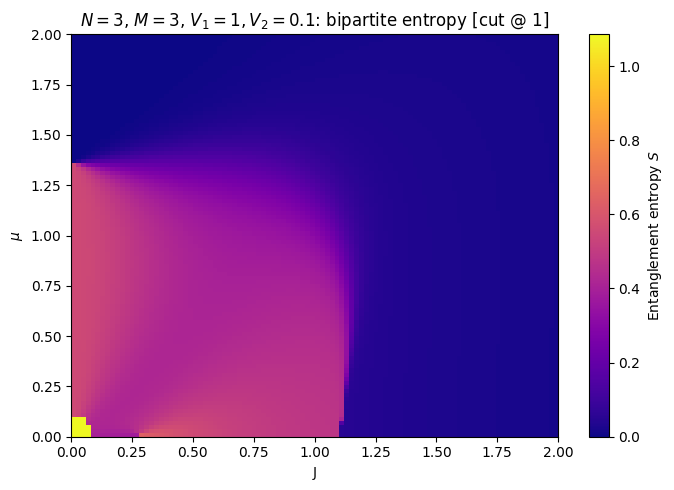

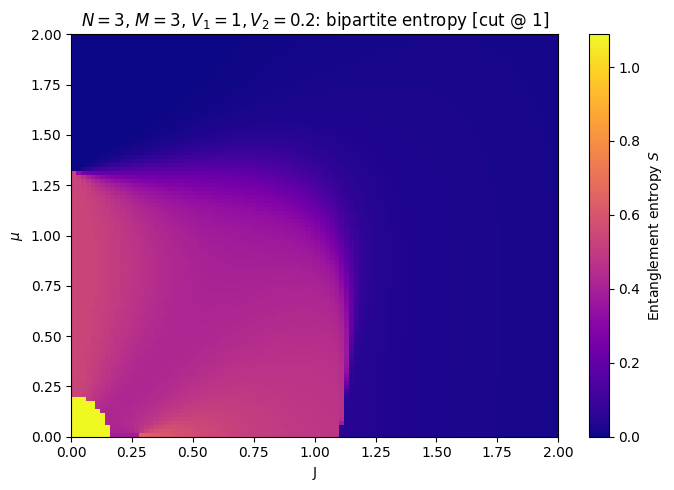

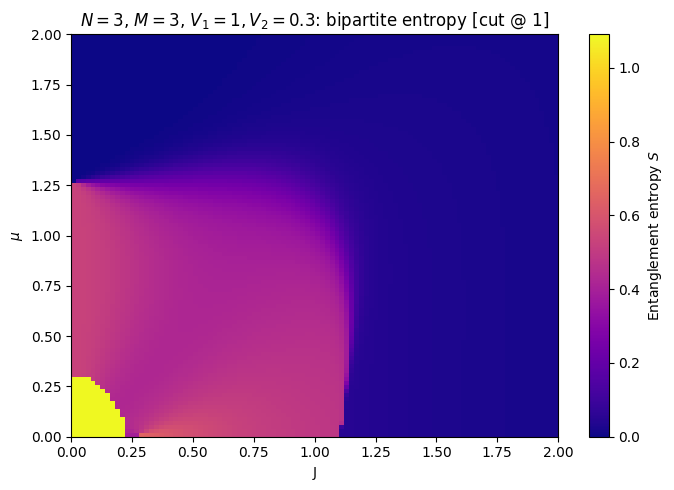

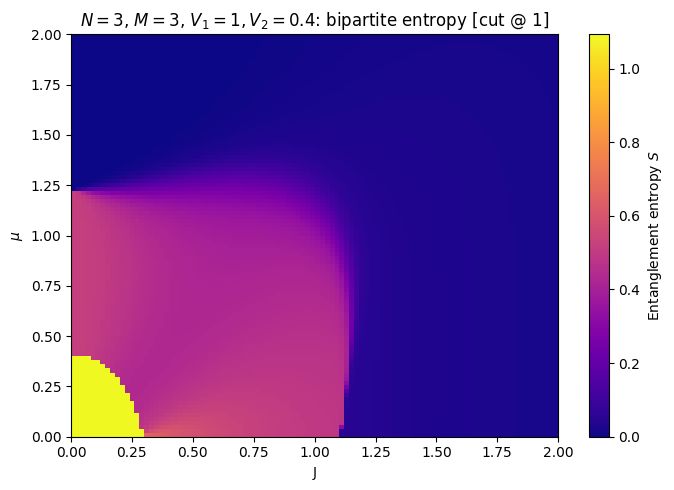

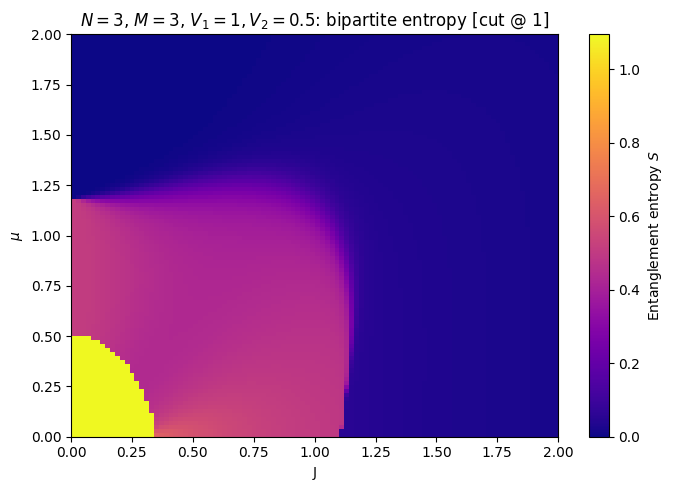

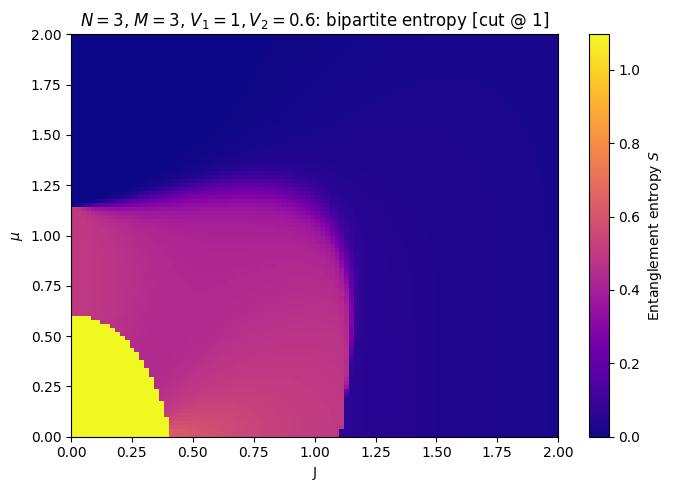

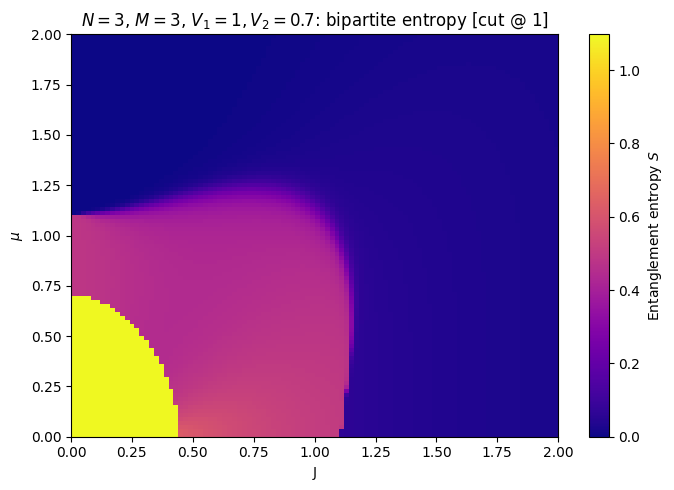

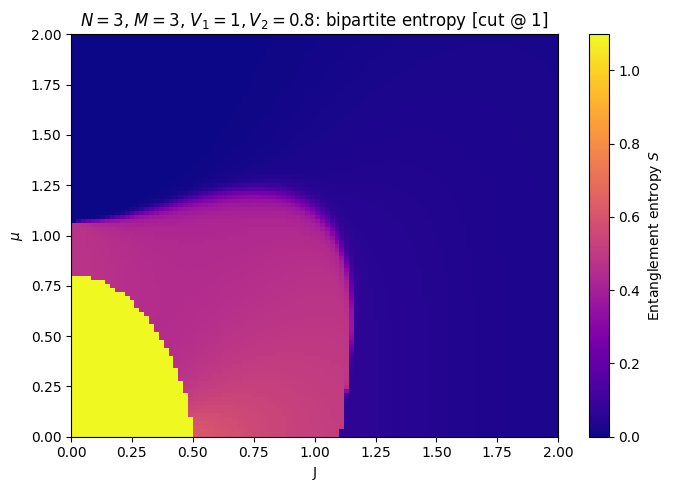

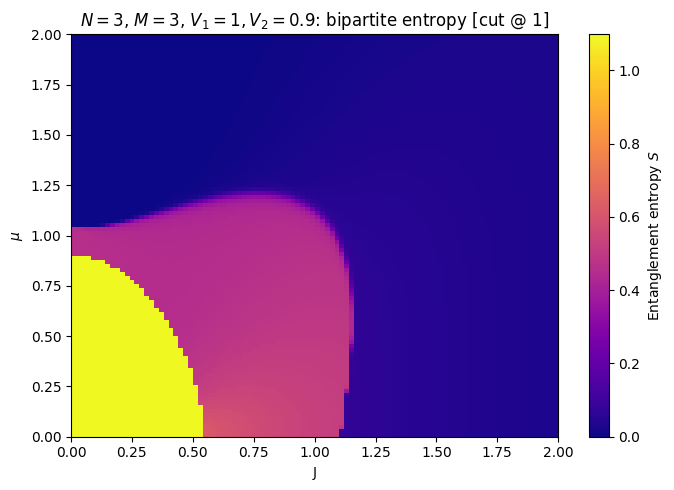

In [37]:
V2s = np.arange(0,1.0,0.1)

for V2 in V2s:
    N = 3
    M = 3
    V = 1

    states, _ = enumerate_states(N, M)

    Js = np.linspace(0, 2, 100)
    mus = np.linspace(0, 2, 100)

    entropy_grid = np.zeros((len(mus), len(Js)), dtype=np.float64)

    # Loop
    for i, mu in enumerate(mus):
        for j, J in enumerate(Js):
            hamiltonian = construct_new_hamiltonian(N, M, V, mu, J, V2 = V2)
            eigenvalues, eigenvectors = exact_diagonalize(hamiltonian)

            P, degenerate_states = construct_ground_state_projector(eigenvalues, eigenvectors)
            d = len(degenerate_states)

            # Entanglement entropy (bipartition in the middle)
            entropies = [compute_entanglement_entropy(N, M, psi, cut_site=N // 2) for psi in degenerate_states]
            entropy_grid[i, j] = np.mean(entropies)
            
    fig, ax = plt.subplots(figsize=(7, 5))
    c = ax.imshow(
        entropy_grid,
        origin='lower',
        aspect='auto',
        extent=[Js[0], Js[-1], mus[0], mus[-1]],
        cmap='plasma',
    )
    fig.colorbar(c, ax=ax, label=r'Entanglement entropy $S$')
    ax.set_xlabel("J")
    ax.set_ylabel(r"$\mu$")
    ax.set_title(f"$N = {N}$, $M = {M}$, $V_1 = {V}, V_2 = {np.round(V2,2)}$: bipartite entropy [cut @ {N//2}]")
    plt.tight_layout()
    plt.show()

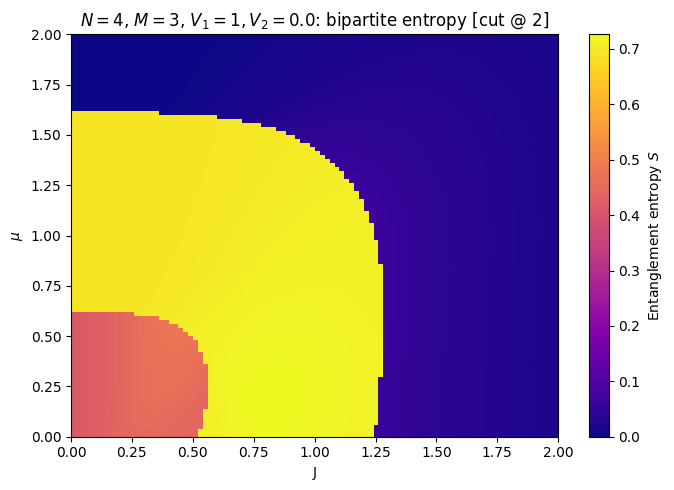

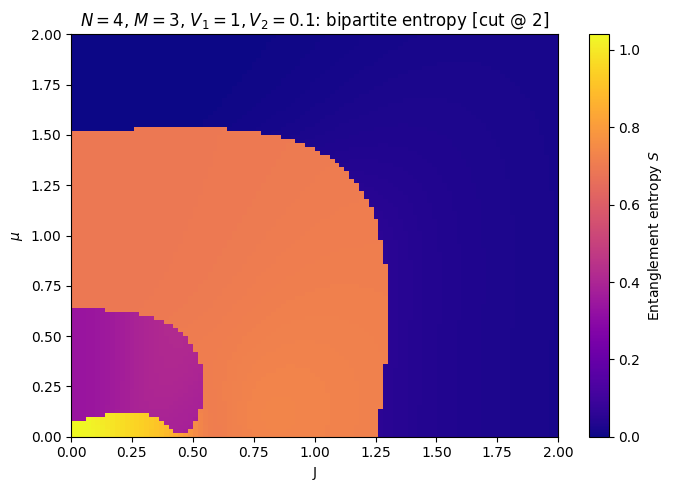

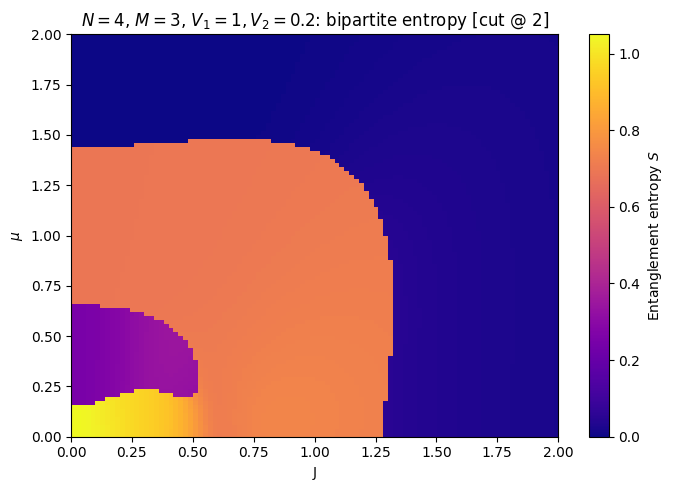

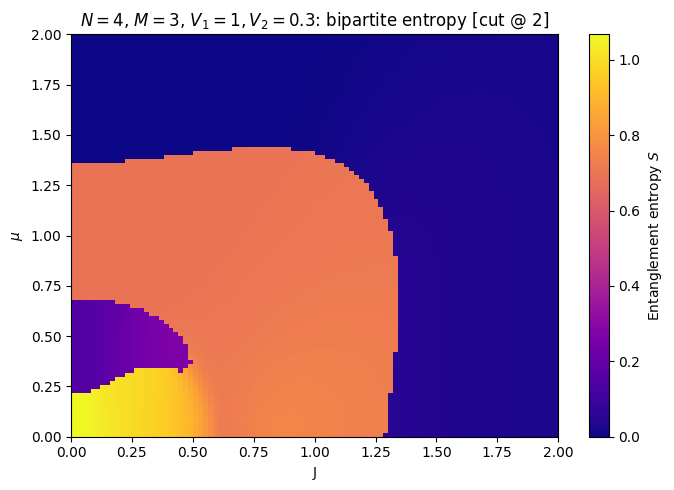

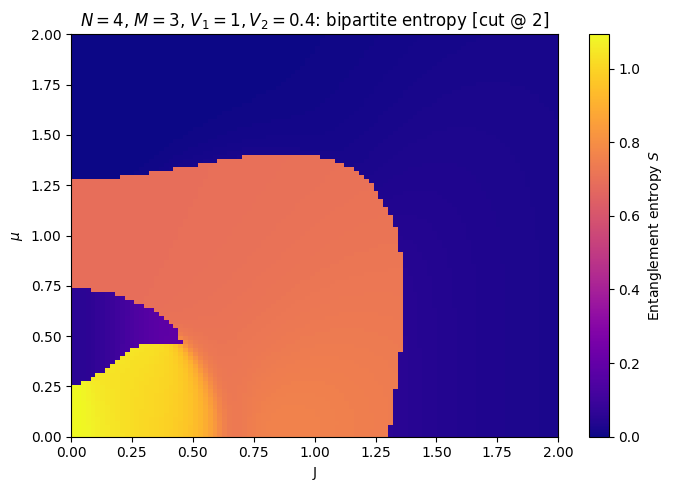

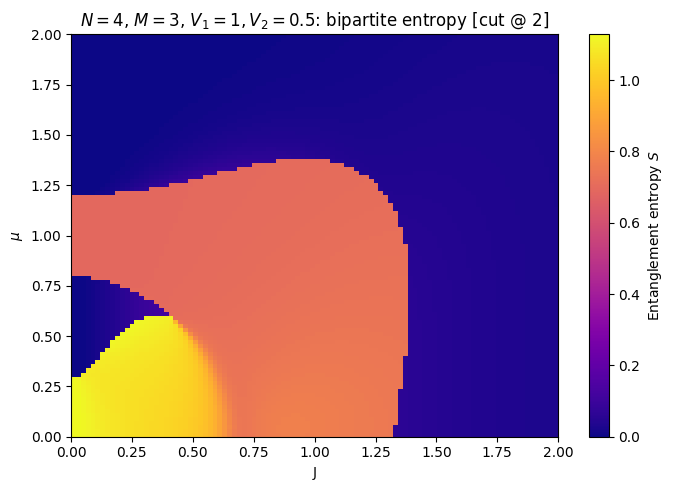

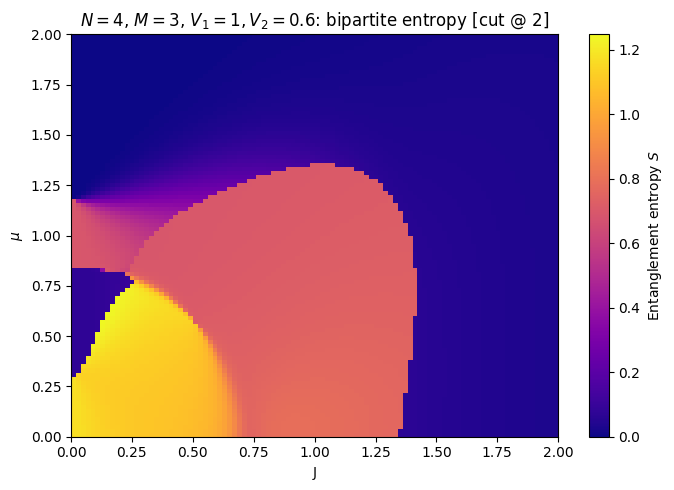

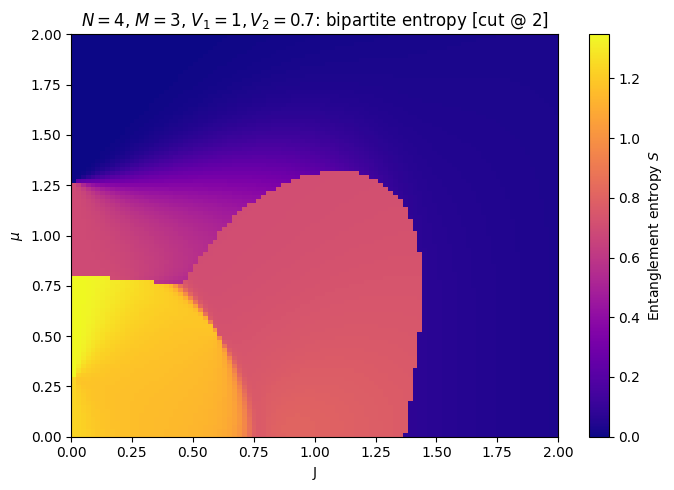

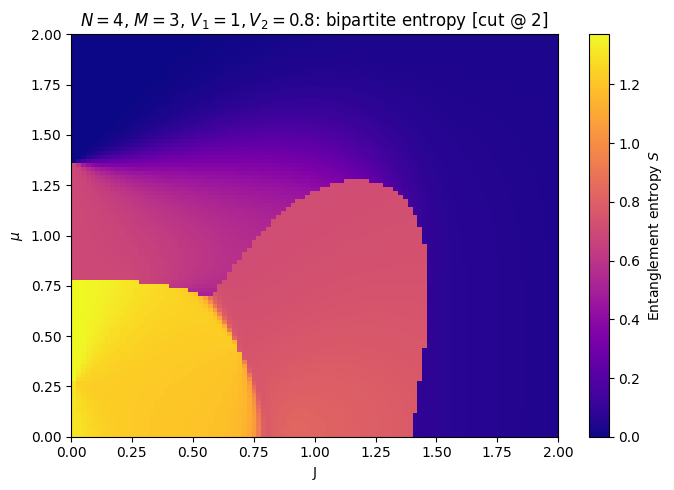

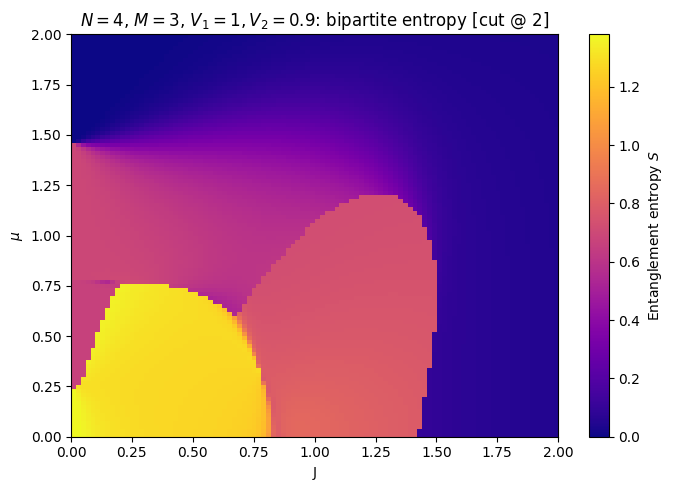

In [38]:
V2s = np.arange(0,1.0,0.1)

for V2 in V2s:
    N = 4
    M = 3
    V = 1

    states, _ = enumerate_states(N, M)

    Js = np.linspace(0, 2, 100)
    mus = np.linspace(0, 2, 100)

    entropy_grid = np.zeros((len(mus), len(Js)), dtype=np.float64)

    # Loop
    for i, mu in enumerate(mus):
        for j, J in enumerate(Js):
            hamiltonian = construct_new_hamiltonian(N, M, V, mu, J, V2 = V2)
            eigenvalues, eigenvectors = exact_diagonalize(hamiltonian)

            P, degenerate_states = construct_ground_state_projector(eigenvalues, eigenvectors)
            d = len(degenerate_states)

            # Entanglement entropy (bipartition in the middle)
            entropies = [compute_entanglement_entropy(N, M, psi, cut_site=N // 2) for psi in degenerate_states]
            entropy_grid[i, j] = np.mean(entropies)
            
    fig, ax = plt.subplots(figsize=(7, 5))
    c = ax.imshow(
        entropy_grid,
        origin='lower',
        aspect='auto',
        extent=[Js[0], Js[-1], mus[0], mus[-1]],
        cmap='plasma',
    )
    fig.colorbar(c, ax=ax, label=r'Entanglement entropy $S$')
    ax.set_xlabel("J")
    ax.set_ylabel(r"$\mu$")
    ax.set_title(f"$N = {N}$, $M = {M}$, $V_1 = {V}, V_2 = {np.round(V2,2)}$: bipartite entropy [cut @ {N//2}]")
    plt.tight_layout()
    plt.show()